## Drive connection and libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import mean_squared_error

## Load data


In [ ]:
csv_files = [[], #Rutas estrategi I
             [], #Rutas estrategi H
             [], #Rutas estrategi R(pi/4)
             []  #Rutas estrategi R(pi)
            ]

for i in range(1, 6):
    csv_files[0].append(f"/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/Executions/{i}/CSV/tabla_strategy_I.csv")
    csv_files[1].append(f"/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/Executions/{i}/CSV/tabla_strategy_H.csv")
    csv_files[2].append(f"/content/drive/MyDrive/Quantum/Code/Result/2_Strategie_R(pi 4)/Executions/{i}/CSV/tabla_strategy_R(pi 4).csv")
    csv_files[3].append(f"/content/drive/MyDrive/Quantum/Code/Result/3_Strategie_R(pi)/Executions/{i}/CSV/tabla_strategy_R(pi).csv")

## Analytical calculation


In [ ]:
gammas = np.linspace(0, np.pi, 31)
print(gammas)

[0.         0.10471976 0.20943951 0.31415927 0.41887902 0.52359878
 0.62831853 0.73303829 0.83775804 0.9424778  1.04719755 1.15191731
 1.25663706 1.36135682 1.46607657 1.57079633 1.67551608 1.78023584
 1.88495559 1.98967535 2.0943951  2.19911486 2.30383461 2.40855437
 2.51327412 2.61799388 2.72271363 2.82743339 2.93215314 3.0368729
 3.14159265]


In [ ]:
PA_I, PB_I, PA_H, PB_H, PA_R_pi_4, PB_R_pi_4, PA_R_pi, PB_R_pi = [], [], [], [], [], [], [], []
for gamma in gammas:
  PA_I.append(3*(np.cos(gamma/2)**2)+2*(np.sin(gamma/2)**2))
  PB_I.append(2*(np.cos(gamma/2)**2)+3*(np.sin(gamma/2)**2))
  PA_H.append((5/4)*((np.cos(gamma/2)+np.sin(gamma/2))**2))
  PB_H.append((5/4)*((np.cos(gamma/2)+np.sin(gamma/2))**2))
  PA_R_pi_4.append(3*((0.8536*np.cos(gamma/2)+0.146*np.sin(gamma/2))**2)+2*((0.8536*np.sin(gamma/2)+0.146*np.cos(gamma/2))**2))
  PB_R_pi_4.append(2*((0.8536*np.cos(gamma/2)+0.146*np.sin(gamma/2))**2)+3*((0.8536*np.sin(gamma/2)+0.146*np.cos(gamma/2))**2))
  PA_R_pi.append(3*(np.sin(gamma/2)**2)+2*(np.cos(gamma/2)**2))
  PB_R_pi.append(2*(np.sin(gamma/2)**2)+3*(np.cos(gamma/2)**2))

In [ ]:
lista_analiticos = {
    "PA_I": PA_I,
    "PB_I": PB_I,
    "PA_H": PA_H,
    "PB_H": PB_H,
    "PA_R(pi/4)": PA_R_pi_4,
    "PB_R(pi/4)": PB_R_pi_4,
    "PA_R(pi)": PA_R_pi,
    "PB_R(pi)": PB_R_pi
}

## Error calculation

In [ ]:
# 1. Read and concatenate, adding 'strategy', 'measurement', 'PB', and 'PA' columns
dfs, df = [], []
for i in range(4):
    if i == 0:
        strategy = "I"
    elif i == 1:
        strategy = "H"
    elif i == 2:
        strategy = "R(pi/4)"
    elif i == 3:
        strategy = "R(pi)"
    for j, path in enumerate(csv_files[i]):
        df = pd.read_csv(path)
        df["strategy"] = strategy
        df["measurement"] = j
        df["PB"] = lista_analiticos[f"PB_{strategy}"]
        df["PA"] = lista_analiticos[f"PA_{strategy}"]
        dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

In [ ]:
# 2. Essential metrics
metrics = [
    "EA_real","ΔEA", "EB_real", "ΔEB","PA", "PB", "Err_Mis_real", "Mis_real"
]

# 3. Average by strategy and measurement
summary = (
    df_all
    .groupby(["strategy", "measurement"])[metrics]
    .mean()
    .round(3)
    .reset_index()
)

In [ ]:
# 4. Calculate ECM by strategy and measurement
ecm_data = []
for [strategy, measurement], group in df_all.groupby(["strategy", "measurement"]):
    ea_ecm = mean_squared_error(group["EA_real"], group["PA"])
    eb_ecm = mean_squared_error(group["EB_real"], group["PB"])
    ecm_data.append({
        "strategy": strategy,
        "measurement": measurement,
        "EA_ECM": round(ea_ecm, 5),
        "EB_ECM": round(eb_ecm, 5)
    })
ecm_df = pd.DataFrame(ecm_data)

In [ ]:
# 5. Join averages with ECM
final_df = pd.merge(summary, em_df, on=["strategy", "measurement"])

# 6. Print final table
print(
    tabulate(
        final_df,
        headers="keys",
        tablefmt="fancy_grid",
        showindex=False
    )
)

╒════════════╤═══════════════╤═══════════╤═══════╤═══════════╤═══════╤═══════╤═══════╤════════════════╤════════════╤══════════╤══════════╕
│ strategy   │   measurement │   EA_real │   ΔEA │   EB_real │   ΔEB │    PA │    PB │   Err_Mis_real │   Mis_real │   EA_ECM │   EB_ECM │
╞════════════╪═══════════════╪═══════════╪═══════╪═══════════╪═══════╪═══════╪═══════╪════════════════╪════════════╪══════════╪══════════╡
│ H          │             0 │     1.914 │ 0.11  │     1.918 │ 0.102 │ 2.019 │ 2.019 │          0.004 │      0.233 │  0.01693 │  0.01651 │
├────────────┼───────────────┼───────────┼───────┼───────────┼───────┼───────┼───────┼────────────────┼────────────┼──────────┼──────────┤
│ H          │             1 │     1.934 │ 0.09  │     1.945 │ 0.075 │ 2.019 │ 2.019 │          0.003 │      0.224 │  0.01331 │  0.01065 │
├────────────┼───────────────┼───────────┼───────┼───────────┼───────┼───────┼───────┼────────────────┼────────────┼──────────┼──────────┤
│ H          │             

In [ ]:
final = (
    final_df
    .groupby(["strategy"])[["EA_ECM", "EB_ECM", "Err_Mis_real", "Mis_real", "PA", "PB"]]
    .mean()
    .round(3)
    .reset_index()
)

print(
    tabulate(
        final,
        headers="keys",
        tablefmt="fancy_grid",
        showindex=False
    )
)

╒════════════╤══════════╤══════════╤════════════════╤════════════╤═══════╤═══════╕
│ strategy   │   EA_ECM │   EB_ECM │   Err_Mis_real │   Mis_real │    PA │    PB │
╞════════════╪══════════╪══════════╪════════════════╪════════════╪═══════╪═══════╡
│ H          │    0.014 │    0.012 │          0.003 │      0.226 │ 2.019 │ 2.019 │
├────────────┼──────────┼──────────┼────────────────┼────────────┼───────┼───────┤
│ I          │    0.021 │    0.016 │          0.002 │      0.045 │ 2.5   │ 2.5   │
├────────────┼──────────┼──────────┼────────────────┼────────────┼───────┼───────┤
│ R(pi)      │    0.012 │    0.018 │          0.002 │      0.042 │ 2.5   │ 2.5   │
├────────────┼──────────┼──────────┼────────────────┼────────────┼───────┼───────┤
│ R(pi/4)    │    0.015 │    0.011 │          0.003 │      0.134 │ 2.258 │ 2.258 │
╘════════════╧══════════╧══════════╧════════════════╧════════════╧═══════╧═══════╛


## Average

In [ ]:
df_m = df_all.groupby(["strategy", "γ"]).mean()[["EA_real", "EB_real"]]

In [ ]:
strategy = ["I", "H", "R(pi/4)", "R(pi)"]

In [ ]:
ME, ds= [], []
for i in strategy:
    df_mean = df_m.groupby("strategy").get_group(i)[["EA_real", "EB_real"]].reset_index(drop=True)
    df_0=(df_all.groupby(["strategy", "measurement"]).get_group((i, 0))[["EA_real", "EB_real"]].reset_index(drop=True) - df_mean)**2
    df_1=(df_all.groupby(["strategy", "measurement"]).get_group((i, 1))[["EA_real", "EB_real"]].reset_index(drop=True) - df_mean)**2
    df_2=(df_all.groupby(["strategy", "measurement"]).get_group((i, 2))[["EA_real", "EB_real"]].reset_index(drop=True) - df_mean)**2
    df_3=(df_all.groupby(["strategy", "measurement"]).get_group((i, 3))[["EA_real", "EB_real"]].reset_index(drop=True) - df_mean)**2
    df_4=(df_all.groupby(["strategy", "measurement"]).get_group((i, 4))[["EA_real", "EB_real"]].reset_index(drop=True) - df_mean)**2
    df_s=np.sqrt(0.25 * (df_0 + df_1 + df_2 + df_3 + df_4))
    df_se=2.7765*(df_s/np.sqrt(5))
    ds.append(np.mean(df_s["EA_real"]))
    ds.append(np.mean(df_s["EB_real"]))
    df_se['strategy'] = i  # Add a strategy column
    ME.append(df_se)

## Graphs

'\npath_payoff = "/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/0_Real_Minimizada_strategy_mean_H.png"\nfig1.savefig(path_payoff, dpi=300, bbox_inches=\'tight\')\nprint(f"[✓] Payoff real guardado en: {path_payoff}")\n'

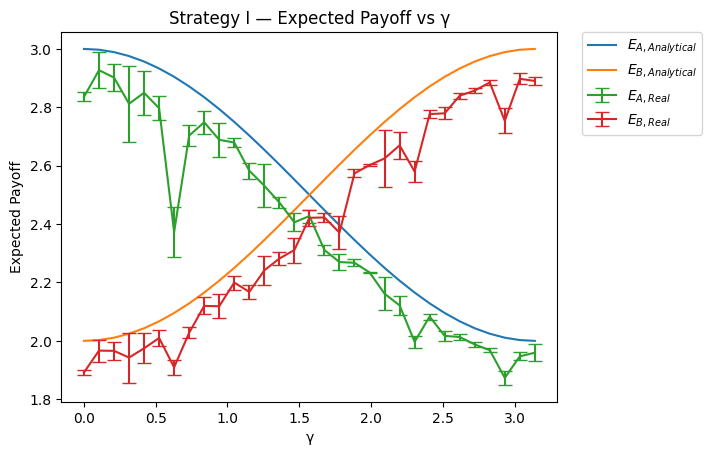

In [ ]:
fig1  = plt.figure()
plt.plot(gammas, PA_I, '-', label='$E_{A, Analytical}$')
plt.plot(gammas, PB_I, '-', label='$E_{B, Analytical}$')
plt.errorbar(gammas, df_m.groupby("strategy").get_group("I")["EA_real"], yerr = ME[0]["EA_real"], fmt='-', label='$E_{A, Real}$', capsize=5)
plt.errorbar(gammas, df_m.groupby("strategy").get_group("I")["EB_real"], yerr = ME[0]["EB_real"], fmt='-', label='$E_{B, Real}$', capsize=5)
plt.title('Strategy I — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

"""
path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/0_Strategie_I/0_Real_Minimizada_strategy_mean_H.png"
fig1.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")
"""

'\npath_payoff = "/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/0_Real_Minimizada_strategy_mean_H.png"\nfig2.savefig(path_payoff, dpi=300, bbox_inches=\'tight\')\nprint(f"[✓] Payoff real guardado en: {path_payoff}")\n'

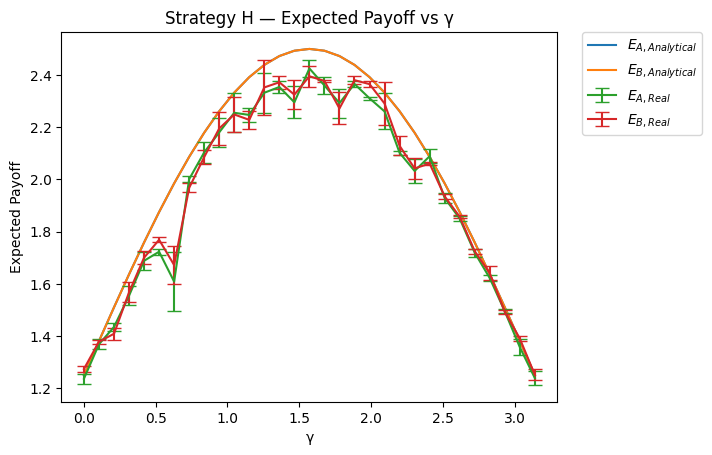

In [ ]:
fig2 = plt.figure()
plt.plot(gammas, PA_H, '-', label='$E_{A, Analytical}$')
plt.plot(gammas, PB_H, '-', label='$E_{B, Analytical}$')
plt.errorbar(gammas, df_m.groupby("strategy").get_group("H")["EA_real"], yerr = ME[1]["EA_real"], fmt='-', capsize=5, label='$E_{A, Real}$', alpha=1)
plt.errorbar(gammas, df_m.groupby("strategy").get_group("H")["EB_real"], yerr = ME[1]["EB_real"], fmt='-', capsize=5, label='$E_{B, Real}$', alpha=1)
plt.title('Strategy H — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

"""
path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/1_Strategie_H/0_Real_Minimizada_strategy_mean_H.png"
fig2.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")
"""

'\npath_payoff = "/content/drive/MyDrive/Quantum/Code/Result/2_Strategie_R(pi 4)/0_Real_Minimizada_strategy_mean_R_pi_4.png"\nfig3.savefig(path_payoff, dpi=300, bbox_inches=\'tight\')\nprint(f"[✓] Payoff real guardado en: {path_payoff}")\n'

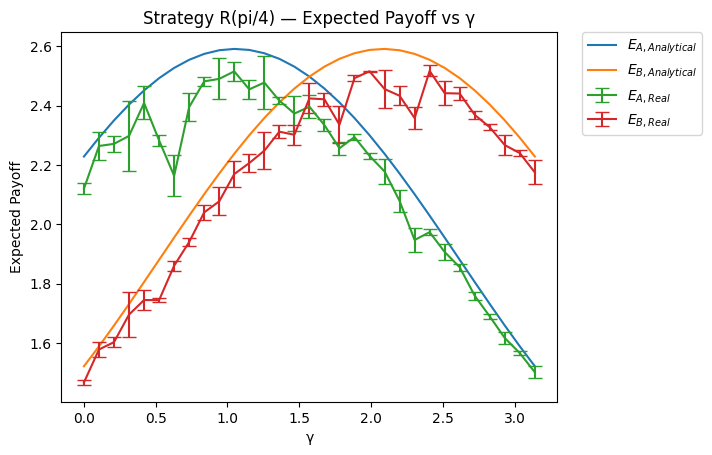

In [ ]:
fig3 = plt.figure()
plt.plot(gammas, PA_R_pi_4, '-', label='$E_{A, Analytical}$')
plt.plot(gammas, PB_R_pi_4, '-', label='$E_{B, Analytical}$')
plt.errorbar(gammas, df_m.groupby("strategy").get_group("R(pi/4)")["EA_real"], yerr = ME[2]["EA_real"], fmt='-', capsize = 5, label='$E_{A, Real}$', alpha=1)
plt.errorbar(gammas, df_m.groupby("strategy").get_group("R(pi/4)")["EB_real"], yerr = ME[2]["EB_real"], fmt='-', capsize = 5, label='$E_{B, Real}$', alpha=1)
plt.title('Strategy R(pi/4) — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

"""
path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/2_Strategie_R(pi 4)/0_Real_Minimizada_strategy_mean_R_pi_4.png"
fig3.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")
"""

'\npath_payoff = "/content/drive/MyDrive/Quantum/Code/Result/3_Strategie_R(pi)/0_Real_Minimizada_strategy_mean_R_pi.png"\nfig4.savefig(path_payoff, dpi=300, bbox_inches=\'tight\')\nprint(f"[✓] Payoff real guardado en: {path_payoff}")\n'

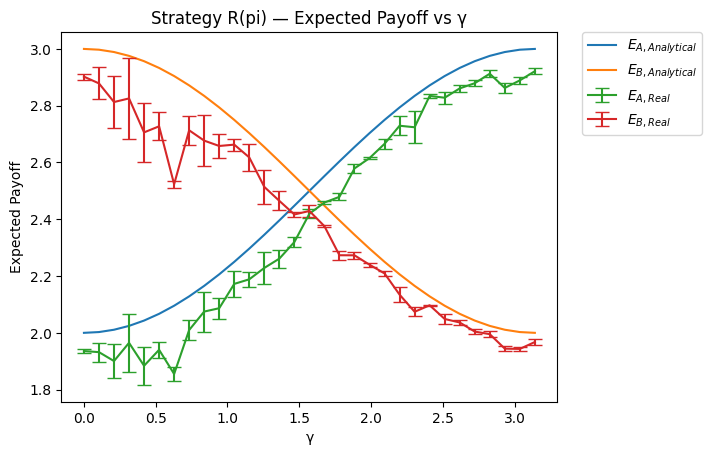

In [ ]:
fig4 = plt.figure()
plt.plot(gammas, PA_R_pi, '-', label='$E_{A, Analytical}$')
plt.plot(gammas, PB_R_pi, '-', label='$E_{B, Analytical}$')
plt.errorbar(gammas, df_m.groupby("strategy").get_group("R(pi)")["EA_real"], yerr = ME[3]["EA_real"], fmt='-', capsize = 5, label='$E_{A, Real}$', alpha=1)
plt.errorbar(gammas, df_m.groupby("strategy").get_group("R(pi)")["EB_real"], yerr = ME[3]["EB_real"], fmt='-', capsize = 5, label='$E_{B, Real}$', alpha=1)
plt.title('Strategy R(pi) — Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
"""
path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/3_Strategie_R(pi)/0_Real_Minimizada_strategy_mean_R_pi.png"
fig4.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")
"""

## Other graphs

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/0_Real_Multiple_Strategy_I.png


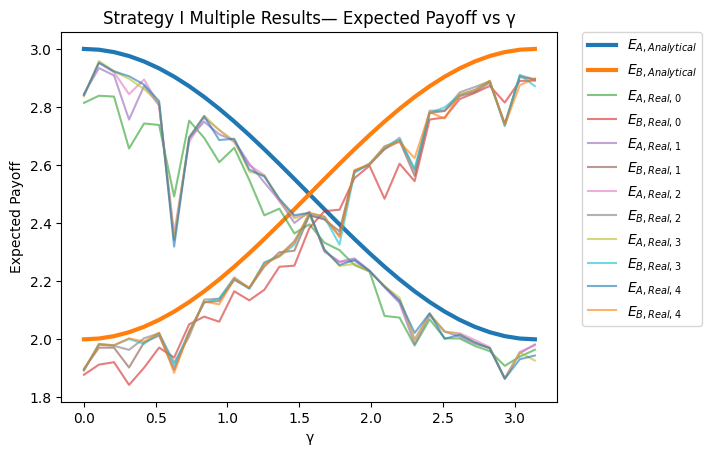

In [ ]:
fig5  = plt.figure()
plt.plot(gammas, PA_I, '-', label='$E_{A, Analytical}$', lw=3)
plt.plot(gammas, PB_I, '-', label='$E_{B, Analytical}$', lw=3)
for i in range(5):
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("I", i))["EA_real"], label='$E_{A, Real, }$'+f'$_{i}$', alpha=0.6)
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("I", i))["EB_real"], label='$E_{B, Real, }$'+f'$_{i}$', alpha=0.6)
plt.title('Strategy I Multiple Results— Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/0_Real_Multiple_Strategy_I.png"
fig5.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/1_Real_Multiple_Strategy_H.png


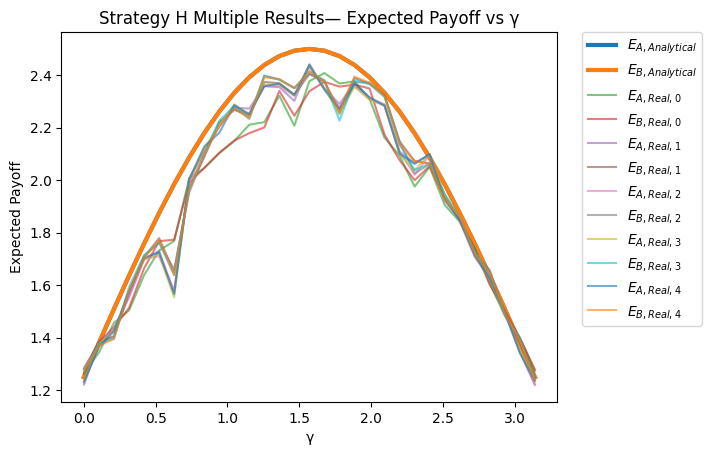

In [ ]:
fig6  = plt.figure()
plt.plot(gammas, PA_H, '-', label='$E_{A, Analytical}$', lw=3)
plt.plot(gammas, PB_H, '-', label='$E_{B, Analytical}$', lw=3)
for i in range(5):
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("H", i))["EA_real"], label='$E_{A, Real, }$'+f'$_{i}$', alpha=0.6)
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("H", i))["EB_real"], label='$E_{B, Real, }$'+f'$_{i}$', alpha=0.6)
plt.title('Strategy H Multiple Results— Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/1_Real_Multiple_Strategy_H.png"
fig6.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/2_Real_Multiple_Strategy_R_pi_4.png


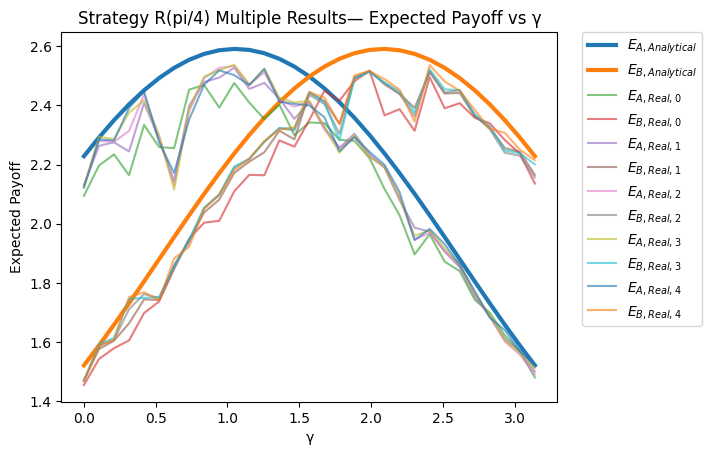

In [ ]:
fig7  = plt.figure()
plt.plot(gammas, PA_R_pi_4, '-', label='$E_{A, Analytical}$', lw=3)
plt.plot(gammas, PB_R_pi_4, '-', label='$E_{B, Analytical}$', lw=3)
for i in range(5):
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("R(pi/4)", i))["EA_real"], label='$E_{A, Real, }$'+f'$_{i}$', alpha=0.6)
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("R(pi/4)", i))["EB_real"], label='$E_{B, Real, }$'+f'$_{i}$', alpha=0.6)
plt.title('Strategy R(pi/4) Multiple Results— Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/2_Real_Multiple_Strategy_R_pi_4.png"
fig7.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")

[✓] Payoff real guardado en: /content/drive/MyDrive/Quantum/Code/Result/3_Real_Multiple_Strategy_R_pi.png


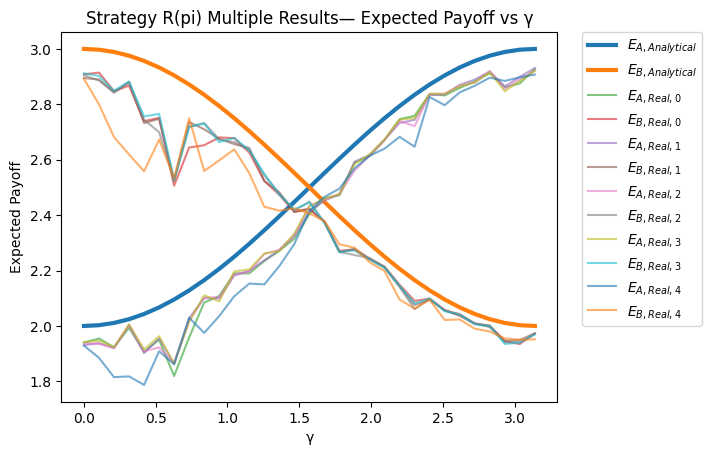

In [ ]:
fig8  = plt.figure()
plt.plot(gammas, PA_R_pi, '-', label='$E_{A, Analytical}$', lw=3)
plt.plot(gammas, PB_R_pi, '-', label='$E_{B, Analytical}$', lw=3)
for i in range(5):
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("R(pi)", i))["EA_real"], label='$E_{A, Real, }$'+f'$_{i}$', alpha=0.6)
    plt.plot(gammas, df_all.groupby(["strategy", "measurement"]).get_group(("R(pi)", i))["EB_real"], label='$E_{B, Real, }$'+f'$_{i}$', alpha=0.6)
plt.title('Strategy R(pi) Multiple Results— Expected Payoff vs γ')
plt.xlabel("γ")
plt.ylabel("Expected Payoff")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

path_payoff = "/content/drive/MyDrive/Quantum/Code/Result/3_Strategie_R(pi)/0_Real_Multiple_Strategy_R_pi.png"
fig8.savefig(path_payoff, dpi=300, bbox_inches='tight')
print(f"[✓] Real payoff saved to: {path_payoff}")
"""

## Fisher's skewness coefficient

In [ ]:
# 2) Define a function to calculate "pure Fisher" skewness (standardized third moment).
def fisher_skewness(arr: np.ndarray) -> float:
    """
    Fisher's skewness coefficient (skewness = m3 / sigma^3).
    arr:  1D numerical array without NaN values.
    """
    x = arr[~np.isnan(arr)]
    n = x.size
    if n < 3:
        return np.nan
    mu    = np.mean(x)
    sigma = np.std(x, ddof=0)  # Population standard deviation
    m3    = np.mean((x - mu)**3)
    if sigma == 0:
        return 0.0
    return m3 / (sigma**3)

In [ ]:
# 3) Variance columns on which we will calculate skewness:
var_cols = ["Var_P00", "Var_P01", "Var_P10", "Var_P11"]

In [ ]:
# 4) Collect skewness results for each strategy:
resultados_skew = {}

for name, df in [("I", df_I), ("H", df_H), ("R(pi/4)", df_R_pi_4), ("R(pi)", df_R_pi)]:
    resultados_skew[name] = {}
    for col in var_cols:
        # Use scipy.stats.skew only as a check; bias=False -> Fisher
        coef_scipy  = st.skew(df[col].dropna(), bias=False)
        coef_manual = fisher_skewness(df[col].values)
        resultados_skew[name][col] = {
            "skew_manual": coef_manual,
            "skew_scipy":  coef_scipy
        }

In [ ]:
# 5) Print a brief summary:
for strat, dic in resultados_skew.items():
    print(f"Strategy {strat}:")
    for col, vals in dic.items():
        print(f"  {col:6s} → skew_manual = {vals['skew_manual']:.5f}, "
              f"skew_scipy = {vals['skew_scipy']:.5f}")
    print()

Estrategia I:
  Var_P00 → skew_manual = 4.94503, skew_scipy = 5.20011
  Var_P01 → skew_manual = 3.92601, skew_scipy = 4.12852
  Var_P10 → skew_manual = 3.85751, skew_scipy = 4.05649
  Var_P11 → skew_manual = 4.79907, skew_scipy = 5.04662

Estrategia H:
  Var_P00 → skew_manual = 5.13986, skew_scipy = 5.40499
  Var_P01 → skew_manual = 1.91002, skew_scipy = 2.00854
  Var_P10 → skew_manual = 2.72907, skew_scipy = 2.86985
  Var_P11 → skew_manual = 3.28359, skew_scipy = 3.45297

Estrategia R(pi/4):
  Var_P00 → skew_manual = 4.77279, skew_scipy = 5.01899
  Var_P01 → skew_manual = 5.07061, skew_scipy = 5.33217
  Var_P10 → skew_manual = 4.17491, skew_scipy = 4.39026
  Var_P11 → skew_manual = 3.34459, skew_scipy = 3.51712

Estrategia R(pi):
  Var_P00 → skew_manual = 5.28064, skew_scipy = 5.55303
  Var_P01 → skew_manual = 5.25077, skew_scipy = 5.52162
  Var_P10 → skew_manual = 3.80897, skew_scipy = 4.00545
  Var_P11 → skew_manual = 4.02245, skew_scipy = 4.22994



# Regarding the payoffs

In [ ]:
# Expected payoff error columns
error_cols = ["ΔEA", "ΔEB"]  # ΔEA = EA_sim - EA_real, ΔEB = EB_sim - EB_real

In [ ]:
# Calculate skewness (manual and with scipy) for ΔEA and ΔEB for each strategy
resultados_error_skew = {}

for name, df in [("I", df_I), ("H", df_H), ("R(pi/4)", df_R_pi_4), ("R(pi)", df_R_pi)]:
    resultados_error_skew[name] = {}
    for col in error_cols:
        coef_scipy  = st.skew(df[col].dropna(), bias=False)
        coef_manual = fisher_skewness(df[col].values)
        resultados_error_skew[name][col] = {
            "skew_manual": coef_manual,
            "skew_scipy":  coef_scipy
        }

In [ ]:
# Print results
for strat, dic in resultados_error_skew.items():
    print(f"Strategy {strat}:")
    for col, vals in dic.items():
        print(f"  {col:4s} → skew_manual = {vals['skew_manual']:.5f}, skew_scipy = {vals['skew_scipy']:.5f}")
    print()

Estrategia I:
  ΔEA  → skew_manual = 1.31261, skew_scipy = 1.38032
  ΔEB  → skew_manual = 2.13293, skew_scipy = 2.24296

Estrategia H:
  ΔEA  → skew_manual = 0.51568, skew_scipy = 0.54228
  ΔEB  → skew_manual = 0.33260, skew_scipy = 0.34976

Estrategia R(pi/4):
  ΔEA  → skew_manual = 1.98259, skew_scipy = 2.08485
  ΔEB  → skew_manual = 0.50818, skew_scipy = 0.53439

Estrategia R(pi):
  ΔEA  → skew_manual = 0.61938, skew_scipy = 0.65133
  ΔEB  → skew_manual = 1.33709, skew_scipy = 1.40607



In [ ]:
df_s = []
for i in strategy:
    df_0=df_all.groupby(["strategy", "measurement"]).get_group((i, 0))[["EA_real", "EB_real"]]
    df_1=df_all.groupby(["strategy", "measurement"]).get_group((i, 1))[["EA_real", "EB_real"]]
    df_2=df_all.groupby(["strategy", "measurement"]).get_group((i, 2))[["EA_real", "EB_real"]]
    df_3=df_all.groupby(["strategy", "measurement"]).get_group((i, 3))[["EA_real", "EB_real"]]
    df_4=df_all.groupby(["strategy", "measurement"]).get_group((i, 4))[["EA_real", "EB_real"]]
    df_mean = df_m.groupby("strategy").get_group(i)[["EA_real", "EB_real"]].reset_index(drop=True)
    df_s.append(np.sqrt(0.25 * ((df_0["EA_real"] - df_mean["EA_real"])**2 + (df_1["EA_real"] - df_mean["EA_real"])**2 + (df_2["EA_real"] - df_mean["EA_real"])**2 + (df_3["EA_real"] - df_mean["EA_real"])**2 +(df_4["EA_real"] - df_mean["EA_real"])**2)))
    df_s.append(np.sqrt(0.25 * ((df_0["EB_real"] - df_mean["EB_real"])**2 + (df_1["EB_real"] - df_mean["EB_real"])**2 + (df_2["EB_real"] - df_mean["EB_real"])**2 + (df_3["EB_real"] - df_mean["EB_real"])**2 +(df_4["EB_real"] - df_mean["EB_real"])**2)))